In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as tt
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 64
N_EPOCHS   = 100
DATA_PATH = './MNIST'
Z_DIM = 2

In [3]:
class VAE(nn.Module):
    def __init__(self, D, d = Z_DIM):
        super(VAE, self).__init__()
        self.encoder = Encoder(d, D)
        self.decoder = Decoder(d, D)
        
        #d - for latent space
        self.d = d
        self.D = D
        
    def count_vlb(self, X, i):
        #get parameters of z distribution
        mu_z, var_z = self.encoder(X)

        #sample latent(mu_z, var_z)
        z = Normal(torch.zeros(mu_z.size()), torch.ones(mu_z.size())).sample()
        z = mu_z + torch.sqrt(var_z) * nn.Parameter(z, requires_grad=False)
              
        #get parameters of x_hat distribution
        mu_x, var_x = self.decoder(z)
                
        normal = Normal(mu_x, torch.sqrt(var_x))
        diagn = torch.distributions.Independent(normal, 1)
         
        #count loss
        latent_loss = 0.5 * torch.sum(var_x + mu_x**2 - torch.log(var_x+1e-12) - 1)
        reconstruction_loss = diagn.log_prob(X)
        
        #coefs are to be chosen
        return -(torch.sum(reconstruction_loss) - latent_loss), latent_loss, torch.sum(reconstruction_loss)
                   
    def generate_samples(self, num_samples):
        z = torch.FloatTensor(np.random.normal(0, 1, size=[num_samples, self.d, 1, 1]))
        return self.decoder(z)

In [4]:
class Encoder(nn.Module):
    def __init__(self, d, D):
        super(Encoder, self).__init__()
        self.D = D
        self.d = d
        
        self.seq = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0)
        )
        
        self.fc_mu = nn.Conv2d(64, Z_DIM, kernel_size=(1, 1), stride=(1, 1))
        self.fc_var = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1)),
            nn.Softplus()
        )
        
    def forward(self, X):
        X = self.seq(X)
        
        mu = self.fc_mu(X)
        var = self.fc_var(X)
        
        return mu, var

In [5]:
class Decoder(nn.Module):
    def __init__(self, d, D):
        super(Decoder, self).__init__()
        self.D = D
        self.d = d
        
        self.seq = nn.Sequential(
            nn.ConvTranspose2d(Z_DIM, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0)
        )
        self.fc_mu = nn.Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
        self.fc_var = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1)),
            nn.Softplus()
        )
        
    def forward(self, X):
        X = self.seq(X)
        
        mu = self.fc_mu(X)
        var = self.fc_var(X)
        
        return mu, var

In [6]:
vae = VAE(49)
vae.load_state_dict(torch.load("vae_weights_poor.pth"))

In [7]:
#transform data to tensor and normalize (values state for MNIST!)
trans = tt.Compose([tt.ToTensor(), tt.Normalize((0.1307,), (0.3081,))]) 

train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True,  transform=trans, download=True) 
test_dataset  = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
test_loader  = DataLoader(dataset=test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

In [8]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(BATCH_SIZE, -1)

In [9]:
class FConvMNIST(nn.Module):
    def __init__(self):
        super(FConvMNIST, self).__init__()
        
        self.conv1   = nn.Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
        self.relu    = nn.LeakyReLU(negative_slope=0.01)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2   = nn.Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1))
        self.flat    = Flatten()
        self.clf     = nn.Linear(in_features=1152, out_features=10, bias=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        return self.clf(self.flat(x)) 

In [10]:
device='cpu'
model = FConvMNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
print("1", model.conv1.weight[0])
model.conv1.weight = nn.Parameter(vae.generate_samples(32)[0])
print("2", model.conv1.weight[0])

1 tensor([[[ 0.1388,  0.0439,  0.0166,  0.0394, -0.0350, -0.0170, -0.1273],
         [ 0.0224, -0.0332, -0.0961, -0.1031,  0.1148, -0.0334,  0.1130],
         [ 0.0829, -0.0657, -0.0702, -0.1327,  0.1286,  0.0862,  0.1243],
         [-0.1400,  0.0953,  0.0309, -0.0088,  0.0448,  0.0271,  0.0378],
         [-0.0952,  0.1046,  0.1334, -0.0874,  0.1298, -0.0181, -0.0207],
         [ 0.0098,  0.0022,  0.0354, -0.0279, -0.1103,  0.1132,  0.1069],
         [ 0.1006,  0.0613, -0.1103,  0.0134,  0.0420, -0.0094,  0.0559]]])
2 tensor([[[ 0.0200,  0.0178,  0.0281,  0.0297,  0.0316,  0.0284,  0.0291],
         [ 0.0150, -0.0104, -0.0288, -0.0375, -0.0385, -0.0126,  0.0228],
         [ 0.0099, -0.0357, -0.0835, -0.1107, -0.1177, -0.0508,  0.0306],
         [ 0.0133, -0.0387, -0.0945, -0.1274, -0.1357, -0.0578,  0.0373],
         [ 0.0178, -0.0303, -0.0786, -0.1062, -0.1054, -0.0281,  0.0565],
         [ 0.0213, -0.0044, -0.0198, -0.0288, -0.0175,  0.0246,  0.0618],
         [ 0.0238,  0.0240,  0.0

In [12]:
loss_list = []
acc_list  = []
test_acc_list = []

N_STEPS = len(train_loader)
print(N_STEPS)

#train network
for j in range(N_EPOCHS):
    for k, (images, labels) in enumerate(train_loader):
        if (images.shape[0] < BATCH_SIZE):
                break
        #forward
        labels = labels.to(device)
        pred = model(images.to(device))
        loss = criterion(pred, labels)
        loss_list.append(loss.item())

        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #statictics
        total = labels.size(0)
        _, predicted = torch.max(pred.data, 1)

        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if j % 4 == 0 and k == 0:
            for i, (test_images, test_labels) in enumerate(test_loader):
                if (test_images.shape[0] < BATCH_SIZE):
                    break
                test_labels = test_labels.to(device)
                pred = model(test_images.to(device))
                optimizer.step()

                #statictics
                total = test_labels.size(0)
                _, predicted = torch.max(pred.data, 1)

                correct = (predicted == test_labels).sum().item()
                test_acc_list.append(correct / total)
                
            print("***stat_block***")
            print("Epoch: ", j, "Step: ", k, "Loss: ", loss.item())
            print("Train_acc: ", (sum(acc_list) / len(acc_list)) * 100)
            print("Test_acc: ", (sum(test_acc_list) / len(test_acc_list)) * 100)

938
***stat_block***
Epoch:  0 Step:  0 Loss:  2.2698795795440674
Train_acc:  21.875
Test_acc:  15.915464743589745
***stat_block***
Epoch:  4 Step:  0 Loss:  0.0008540319395251572
Train_acc:  90.27490664177114
Test_acc:  36.65364583333333
***stat_block***
Epoch:  8 Step:  0 Loss:  0.07792149484157562
Train_acc:  93.39819261037748
Test_acc:  31.453659188034187
***stat_block***
Epoch:  12 Step:  0 Loss:  0.06312043219804764
Train_acc:  94.3377612272121
Test_acc:  35.33153044871795
***stat_block***
Epoch:  16 Step:  0 Loss:  0.11340978741645813
Train_acc:  95.10261038484626
Test_acc:  33.062900641025635
***stat_block***
Epoch:  20 Step:  0 Loss:  0.15314257144927979
Train_acc:  95.27089669708127
Test_acc:  31.95779914529914
***stat_block***
Epoch:  24 Step:  0 Loss:  0.10230546444654465
Train_acc:  95.45506970074258
Test_acc:  32.2101076007326
***stat_block***
Epoch:  28 Step:  0 Loss:  0.19477829337120056
Train_acc:  95.61842531539429
Test_acc:  32.46569511217949
***stat_block***
Epoch: 

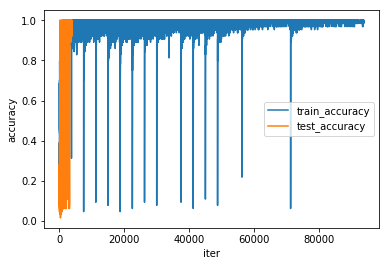

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([i for i in range(len(acc_list))], acc_list, label = 'train_accuracy')
plt.plot([i for i in range(len(test_acc_list))], test_acc_list, label = 'test_accuracy')

plt.xlabel('iter')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [14]:
model = FConvMNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [15]:
vanilla_loss_list = []
vanilla_acc_list  = []
vanilla_test_acc_list = []

N_STEPS = len(train_loader)
print(N_STEPS)

#train network
for j in range(N_EPOCHS):
    for k, (images, labels) in enumerate(train_loader):
        if (images.shape[0] < BATCH_SIZE):
                break
        #forward
        labels = labels.to(device)
        pred = model(images.to(device))
        loss = criterion(pred, labels)
        vanilla_loss_list.append(loss.item())

        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #statictics
        total = labels.size(0)
        _, predicted = torch.max(pred.data, 1)

        correct = (predicted == labels).sum().item()
        vanilla_acc_list.append(correct / total)

        if j % 4 == 0 and k == 0:
            for i, (test_images, test_labels) in enumerate(test_loader):
                if (i > 20 or test_images.shape[0] < BATCH_SIZE):
                    break
                test_labels = test_labels.to(device)
                pred = model(test_images.to(device))
                optimizer.step()

                #statictics
                total = test_labels.size(0)
                _, predicted = torch.max(pred.data, 1)

                correct = (predicted == test_labels).sum().item()
                vanilla_test_acc_list.append(correct / total)
                
            print("***stat_block***")
            print("Epoch: ", j, "Step: ", k, "Loss: ", loss.item())
            print("Train_acc: ", (sum(vanilla_acc_list) / len(vanilla_acc_list)) * 100)
            print("Test_acc: ", (sum(vanilla_test_acc_list) / len(vanilla_test_acc_list)) * 100)

938
***stat_block***
Epoch:  0 Step:  0 Loss:  2.3168842792510986
Train_acc:  17.1875
Test_acc:  16.964285714285715
***stat_block***
Epoch:  4 Step:  0 Loss:  0.0401463508605957
Train_acc:  96.82915444118431
Test_acc:  44.60565476190476
***stat_block***
Epoch:  8 Step:  0 Loss:  0.016321390867233276
Train_acc:  97.92687908496733
Test_acc:  61.458333333333336
***stat_block***
Epoch:  12 Step:  0 Loss:  0.012807749211788177
Train_acc:  98.45778679413073
Test_acc:  69.21502976190477
***stat_block***
Epoch:  16 Step:  0 Loss:  0.00014500549877993762
Train_acc:  98.75723254185287
Test_acc:  75.04464285714286
***stat_block***
Epoch:  20 Step:  0 Loss:  0.00010264674347126856
Train_acc:  98.9676711488181
Test_acc:  78.9310515873016
***stat_block***
Epoch:  24 Step:  0 Loss:  9.934773697750643e-05
Train_acc:  99.10963415447553
Test_acc:  81.71768707482994
***stat_block***
Epoch:  28 Step:  0 Loss:  1.9746348698390648e-05
Train_acc:  99.21657630445554
Test_acc:  83.72395833333334
***stat_block*

KeyboardInterrupt: 

/home/daha-kot/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/daha-kot/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


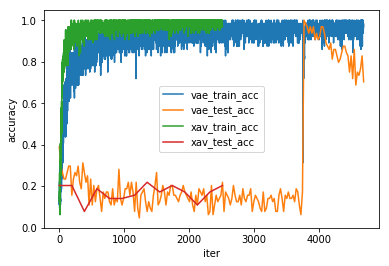

In [28]:
plt.figure()
plt.plot([i for i in range(len(acc_list)//20)], acc_list[:(len(acc_list)//20)], label = 'vae_train_acc')
plt.plot(np.linspace(0, len(acc_list)//20, len(test_acc_list)/20), test_acc_list[:len(test_acc_list)//20], label = 'vae_test_acc')
plt.plot([i for i in range(len(vanilla_acc_list)//20)], vanilla_acc_list[:len(vanilla_acc_list)//20], label = 'xav_train_acc')
plt.plot(np.linspace(0, len(vanilla_acc_list)/20, len(vanilla_test_acc_list)/20), vanilla_test_acc_list[:len(vanilla_test_acc_list)//20], label = 'xav_test_acc')

plt.xlabel('iter')
plt.ylabel('accuracy')
plt.legend()

plt.show()